In [1]:
import torch
import pickle
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

DATA Visualization

In [2]:
df = pd.read_excel('APY_Rice.xls')

In [3]:
df.head

<bound method NDFrame.head of                              State     District      Year       Season  \
0      Andaman and Nicobar Islands   2.NICOBARS   2000-01  Kharif        
1      Andaman and Nicobar Islands   2.NICOBARS   2001-02  Kharif        
2      Andaman and Nicobar Islands   2.NICOBARS   2002-03  Kharif        
3      Andaman and Nicobar Islands   2.NICOBARS   2003-04  Kharif        
4      Andaman and Nicobar Islands   2.NICOBARS   2004-05  Kharif        
...                            ...          ...       ...          ...   
27282                          NaN          NaN       NaN          NaN   
27283                          NaN          NaN       NaN          NaN   
27284                          NaN          NaN       NaN          NaN   
27285                          NaN          NaN       NaN          NaN   
27286                          NaN          NaN       NaN          NaN   

       Area (Hectare)  Production (Tonnes)  Yield (Tonnes/Hectare)  
0           

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27287 entries, 0 to 27286
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   25483 non-null  object 
 1   District                27130 non-null  object 
 2   Year                    27195 non-null  object 
 3   Season                  27130 non-null  object 
 4   Area (Hectare)          27153 non-null  float64
 5   Production (Tonnes)     27113 non-null  float64
 6   Yield (Tonnes/Hectare)  27153 non-null  float64
dtypes: float64(3), object(4)
memory usage: 1.5+ MB


In [5]:
df.columns

Index(['State', 'District', 'Year', 'Season', 'Area (Hectare)',
       'Production (Tonnes)', 'Yield (Tonnes/Hectare)'],
      dtype='object')

In [6]:
sum_maxp = df["Production (Tonnes)"].sum()
df["percent_of_production"] = df["Production (Tonnes)"].map(lambda x:(x/sum_maxp)*100)

In [7]:
df.shape

(27287, 8)

In [8]:
df.dtypes

State                      object
District                   object
Year                       object
Season                     object
Area (Hectare)            float64
Production (Tonnes)       float64
Yield (Tonnes/Hectare)    float64
percent_of_production     float64
dtype: object

In [9]:
df.isnull().sum()

State                     1804
District                   157
Year                        92
Season                     157
Area (Hectare)             134
Production (Tonnes)        174
Yield (Tonnes/Hectare)     134
percent_of_production      174
dtype: int64

In [10]:
df.dropna(inplace=True)

In [11]:
df.isna().sum()
cols = ['Area (Hectare)', 'Yield (Tonnes/Hectare)', 'percent_of_production', 'Production (Tonnes)']

Data Pre-Processing

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

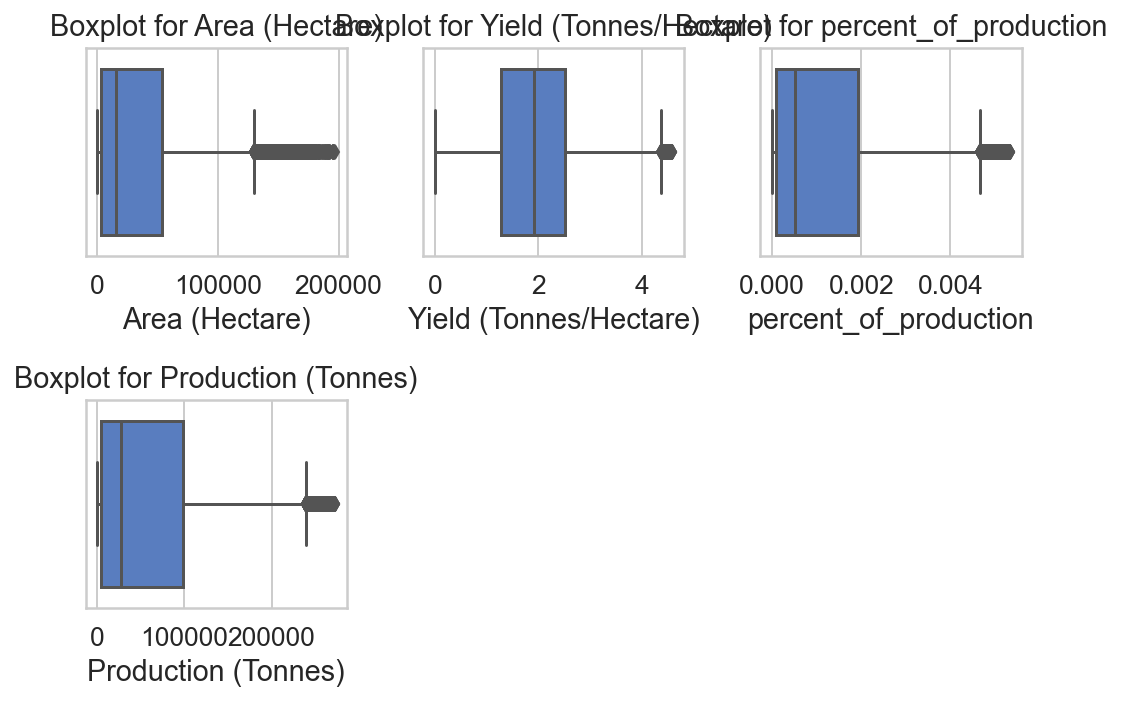

In [12]:
for temp in cols:
  Q1 = df[temp].quantile(0.25)
  Q3 = df[temp].quantile(0.75)
  IQR = Q3 - Q1

  # identify outliers
  threshold = 1.5
  outliers = df[(df[temp] < Q1 - threshold * IQR) | (df[temp] > Q3 + threshold * IQR)]
  df.drop(outliers.index,inplace=True)
  plt.figure(figsize=(7,7))
for j , col in enumerate(cols):
    plt.subplot(3, 3, j + 1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot for {col}')

plt.tight_layout()
plt.show()

In [13]:
for i in df.columns:
    print(i,"  ",df[i].unique())

State    ['Andaman and Nicobar Islands' 'Andhra Pradesh' 'Arunachal Pradesh'
 'Assam' 'Bihar' 'Chandigarh' 'Chhattisgarh' 'Dadra and Nagar Haveli'
 'Daman and Diu' 'Delhi' 'Goa' 'Gujarat' 'Haryana' 'Himachal Pradesh'
 'Jammu and Kashmir ' 'Jharkhand' 'Karnataka' 'Kerala' 'Madhya Pradesh'
 'Maharashtra' 'Manipur' 'Meghalaya' 'Mizoram' 'Nagaland' 'Odisha'
 'Puducherry' 'Punjab' 'Rajasthan' 'Sikkim' 'Tamil Nadu' 'Telangana '
 'THE DADRA AND NAGAR HAVELI AND DAMAN AND DIU' 'Tripura' 'Uttar Pradesh'
 'Uttarakhand']
District    [' 2.NICOBARS' ' 3.NORTH AND MIDDLE ANDAMAN' ' 4.SOUTH ANDAMANS'
 ' 1.ADILABAD' ' 2.ANANTAPUR' ' 3.CHITTOOR' ' 5.GUNTUR' ' 6.HYDERABAD'
 ' 7.KADAPA' ' 8.KARIMNAGAR' ' 9.KHAMMAM' ' 10.KRISHNA' ' 11.KURNOOL'
 ' 12.MAHBUBNAGAR' ' 13.MEDAK' ' 14.NALGONDA' ' 15.NIZAMABAD'
 ' 16.PRAKASAM' ' 17.RANGAREDDI' ' 18.SPSR NELLORE' ' 19.SRIKAKULAM'
 ' 20.VISAKHAPATANAM' ' 21.VIZIANAGARAM' ' 22.WARANGAL' ' 1.ANJAW'
 ' 2.CHANGLANG' ' 3.DIBANG VALLEY' ' 4.EAST KAMENG' ' 5.EAST SIANG'


In [14]:
df['Season'].unique()

array(['Kharif     ', 'Autumn     ', 'Rabi       ', 'Total',
       'Summer     ', 'Winter     ', 'Whole Year '], dtype=object)

In [15]:
for state in df['State'].unique():
    # Extract unique districts for the current state
    districts = df[df['State'] == state]['District'].unique()
    
    # Concatenate districts into a single string
    district_str = ", ".join(districts)
    
    # Print the state and its districts
    print(f"State: {state}")
    print(f"Districts: {district_str}")
    print()

State: Andaman and Nicobar Islands
Districts:  2.NICOBARS,  3.NORTH AND MIDDLE ANDAMAN,  4.SOUTH ANDAMANS

State: Andhra Pradesh
Districts:  1.ADILABAD,  2.ANANTAPUR,  3.CHITTOOR,  5.GUNTUR,  6.HYDERABAD,  7.KADAPA,  8.KARIMNAGAR,  9.KHAMMAM,  10.KRISHNA,  11.KURNOOL,  12.MAHBUBNAGAR,  13.MEDAK,  14.NALGONDA,  15.NIZAMABAD,  16.PRAKASAM,  17.RANGAREDDI,  18.SPSR NELLORE,  19.SRIKAKULAM,  20.VISAKHAPATANAM,  21.VIZIANAGARAM,  22.WARANGAL

State: Arunachal Pradesh
Districts:  1.ANJAW,  2.CHANGLANG,  3.DIBANG VALLEY,  4.EAST KAMENG,  5.EAST SIANG,  6.KAMLE,  7.KRA DAADI,  8.KURUNG KUMEY,  9.LEPARADA,  10.LOHIT,  11.LONGDING,  12.LOWER DIBANG VALLEY,  13.LOWER SIANG,  14.LOWER SUBANSIRI,  15.NAMSAI,  16.PAKKE KESSANG,  17.PAPUM PARE,  18.SHI YOMI,  19.SIANG,  20.TAWANG,  21.TIRAP,  22.UPPER SIANG,  23.UPPER SUBANSIRI,  24.WEST KAMENG,  25.WEST SIANG

State: Assam
Districts:  1.BAKSA,  2.BARPETA,  3.BONGAIGAON,  4.CACHAR,  5.CHIRANG,  6.DARRANG,  7.DHEMAJI,  8.DHUBRI,  9.DIBRUGARH,  10.DIMA

<AxesSubplot:xlabel='Production', ylabel='State'>

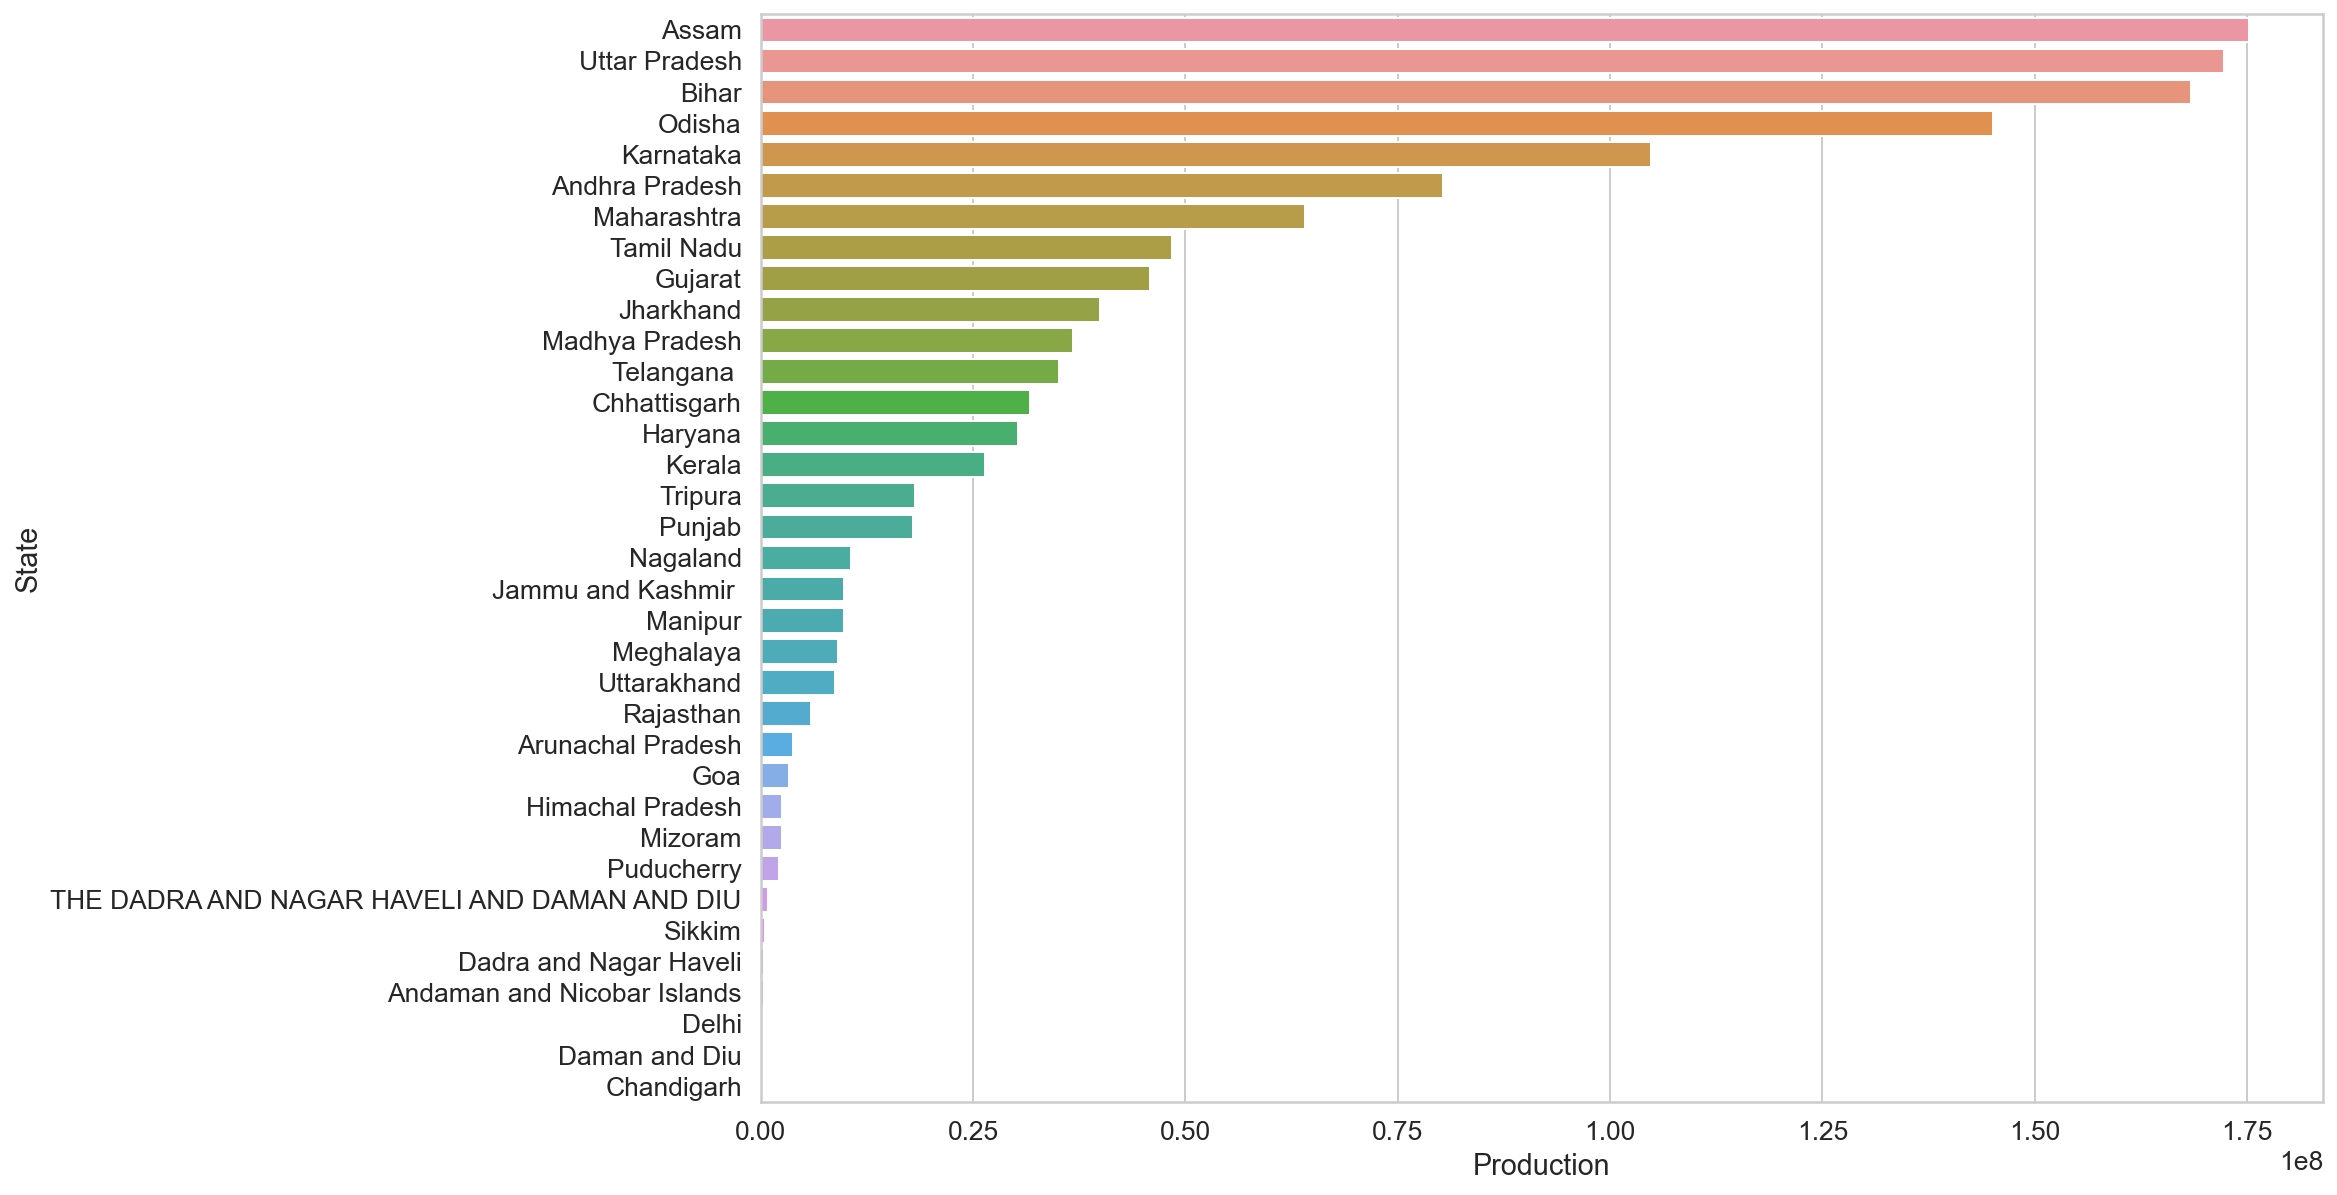

In [16]:
state_budget=df.groupby('State')['Production (Tonnes)'].sum()
state_budget=state_budget.sort_values(ascending=False)
plt.xlabel('Production')
sns.barplot(x=state_budget.values,y=state_budget.index)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

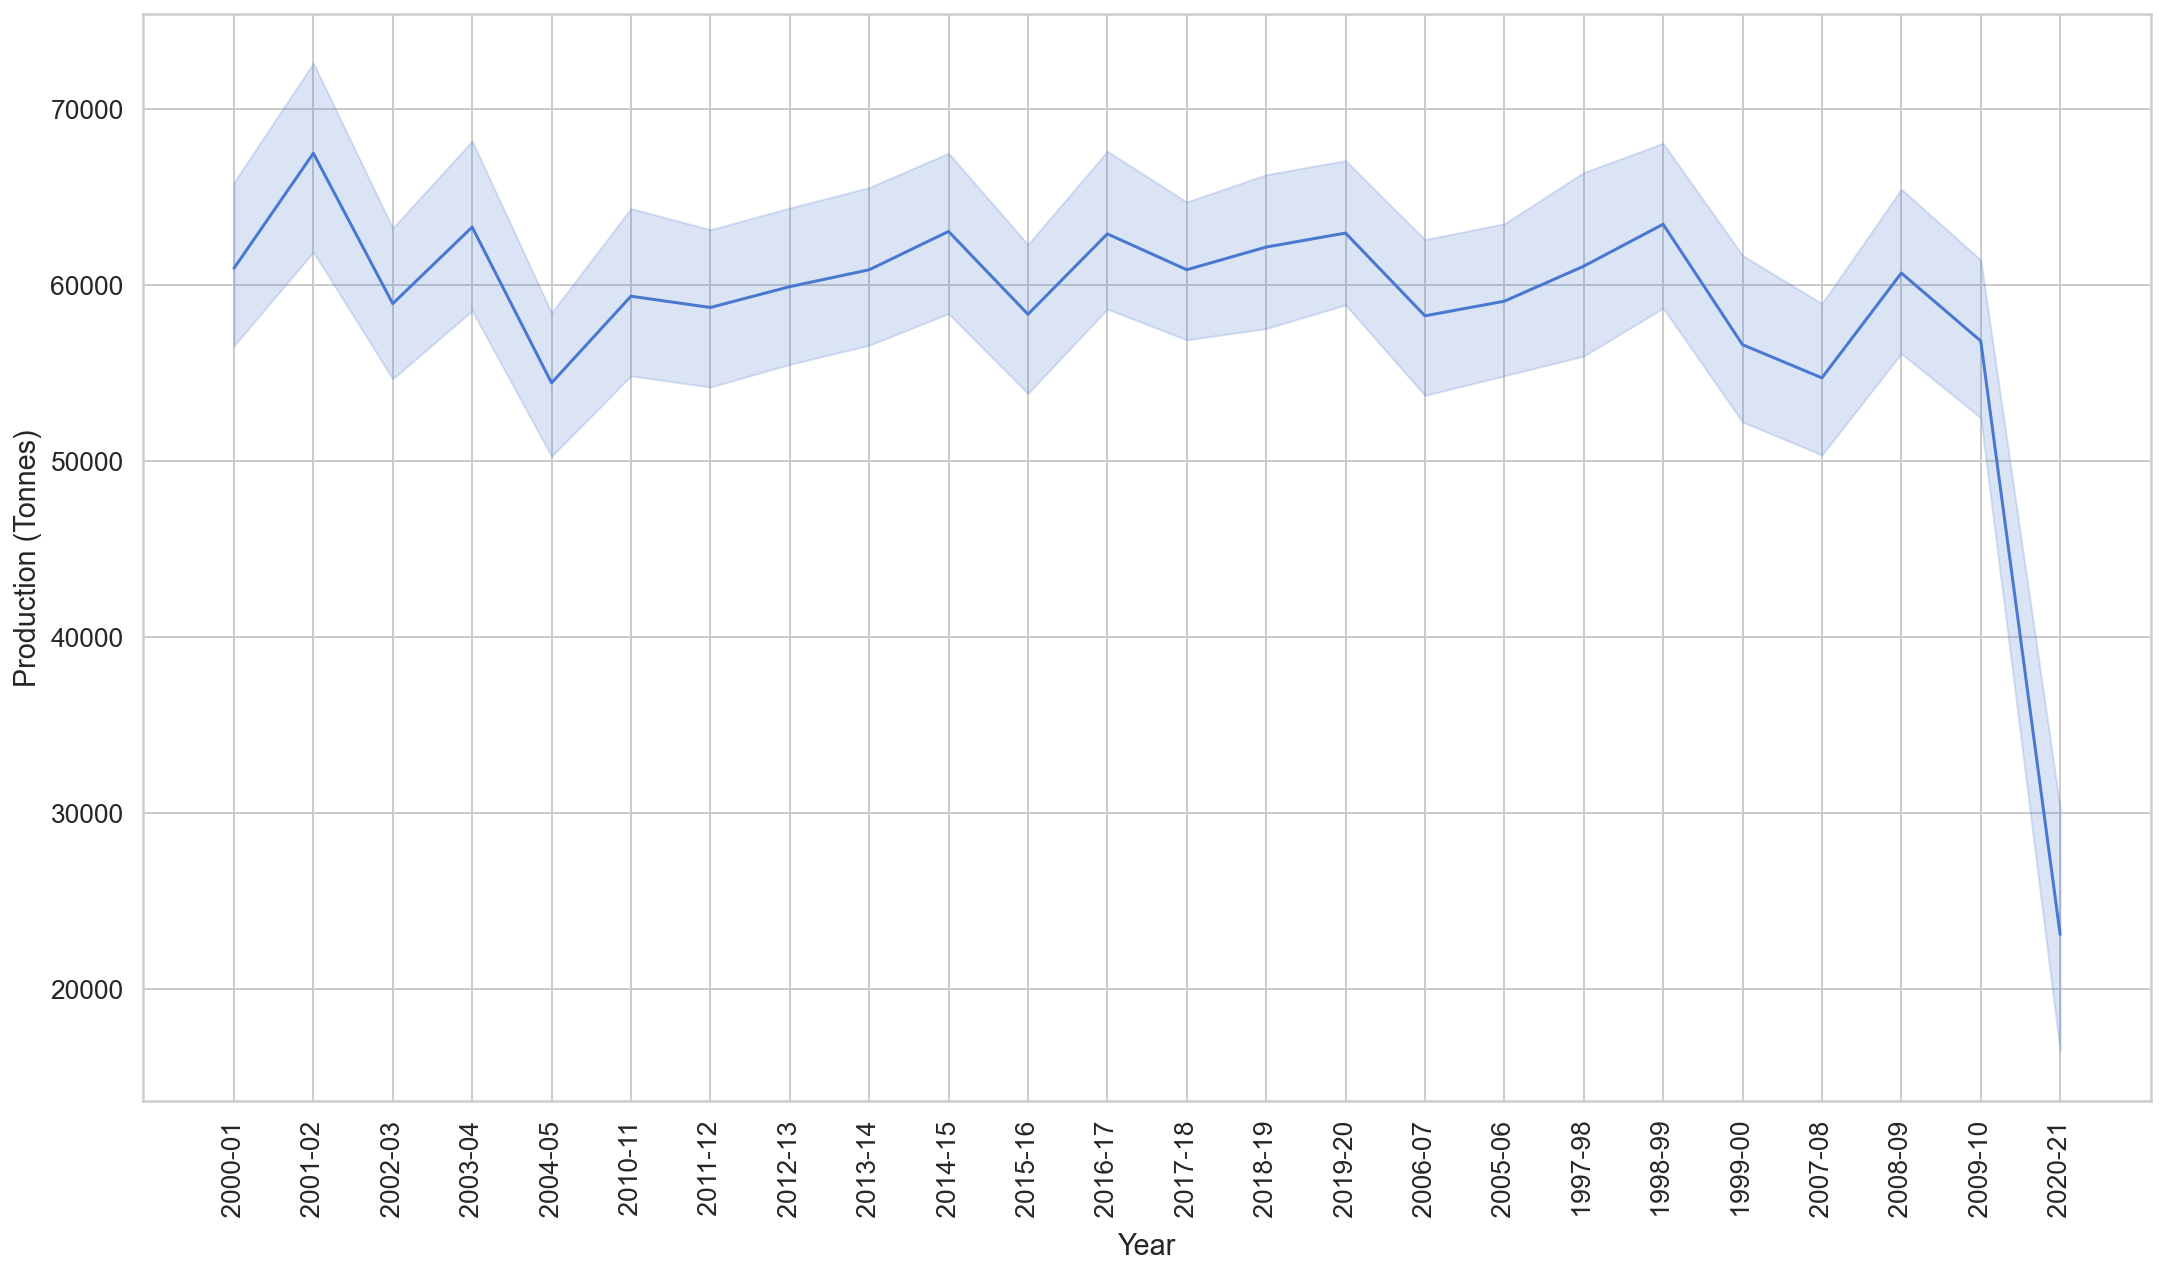

In [17]:
plt.figure(figsize=(18,10))
sns.lineplot(x=df['Year'],y=df['Production (Tonnes)'])
plt.xticks(rotation=90)

<AxesSubplot:xlabel='Season'>

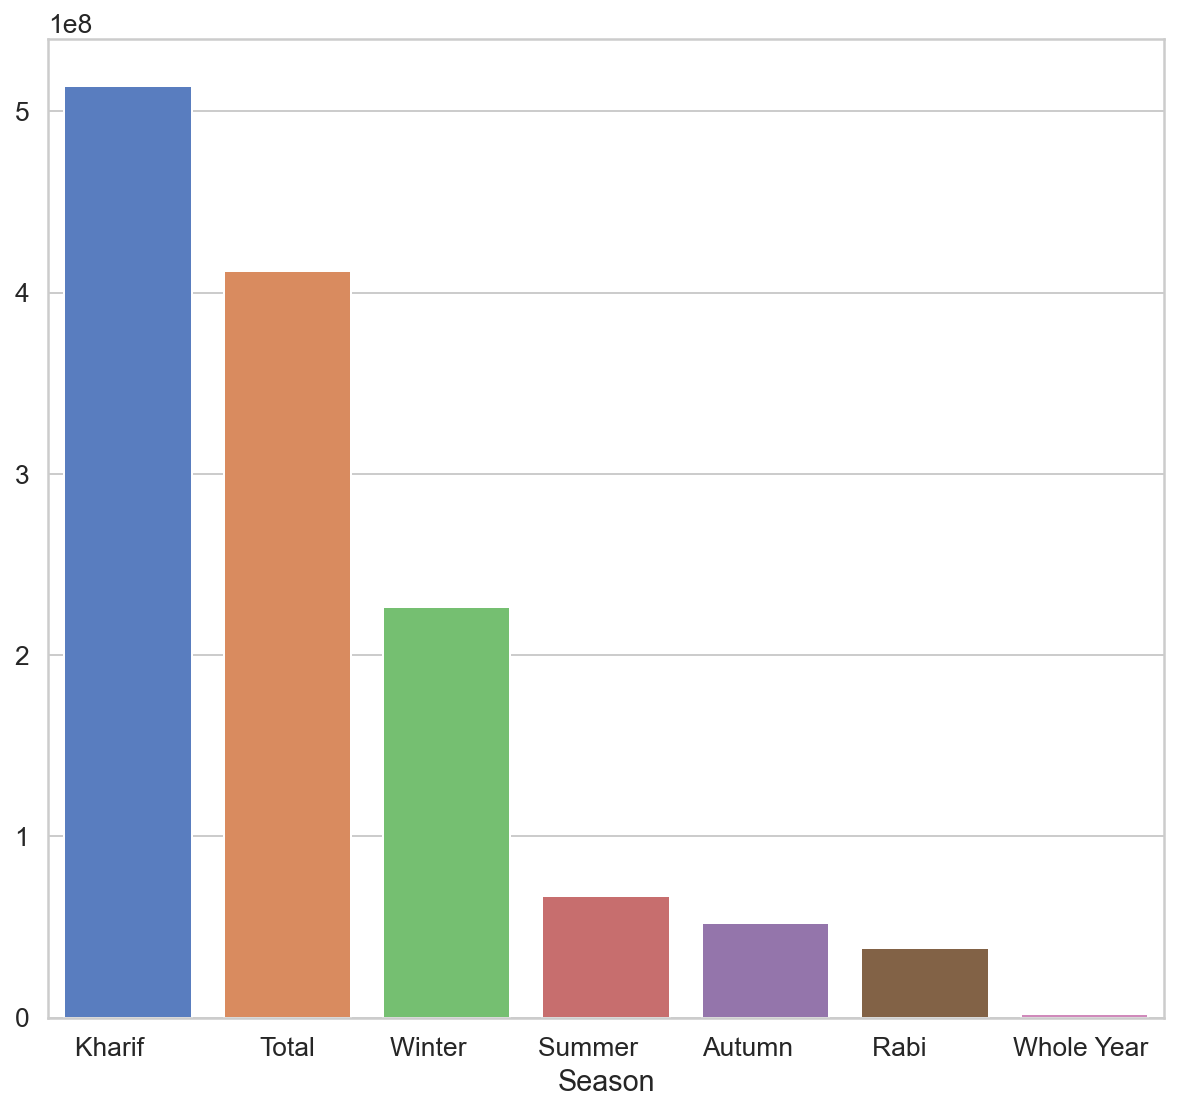

In [18]:
plt.figure(figsize=(10,9))
season_budget=df.groupby('Season')['Production (Tonnes)'].sum()
season_budget=season_budget.sort_values(ascending=False)
sns.barplot(y=season_budget.values,x=season_budget.index)

(array([    0.,  5000., 10000.]), [])

<Figure size 720x720 with 0 Axes>

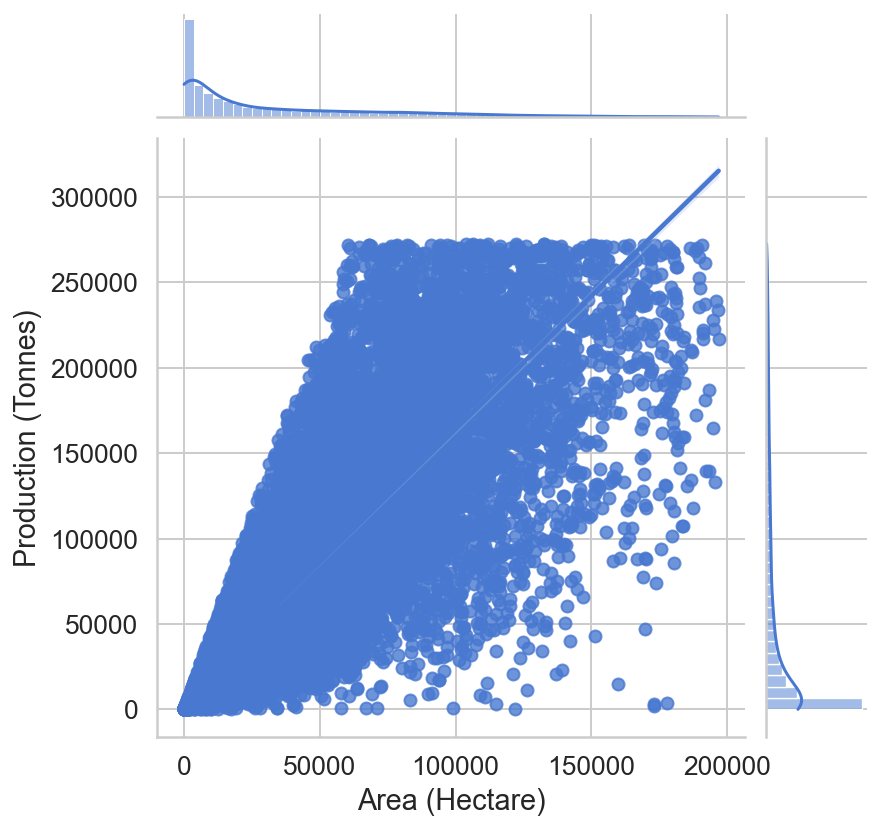

In [19]:
plt.figure(figsize=(10,10))
sns.jointplot(x="Area (Hectare)", y="Production (Tonnes)", data=df,kind='reg')
plt.xticks(rotation=90)

Split the data

In [20]:
data1 = df.drop(["District","Year"],axis=1)
data2 = df.drop(["District"],axis=1)

In [21]:
data_dum = pd.get_dummies(data1)
data_dum1 = pd.get_dummies(data2)
data_dum[:5]

,Area (Hectare),Production (Tonnes),Yield (Tonnes/Hectare),percent_of_production,State_Andaman and Nicobar Islands,State_Andhra Pradesh,State_Arunachal Pradesh,State_Assam,State_Bihar,State_Chandigarh,...,State_Tripura,State_Uttar Pradesh,State_Uttarakhand,Season_Autumn,Season_Kharif,Season_Rabi,Season_Summer,Season_Total,Season_Whole Year,Season_Winter
0,102.00,321.00,3.147059,0.000006,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,83.00,300.00,3.614458,0.000006,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,189.20,510.84,2.700000,0.000010,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,52.00,90.17,1.734038,0.000002,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,52.94,72.57,1.370797,0.000001,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [22]:
df.dtypes

State                      object
District                   object
Year                       object
Season                     object
Area (Hectare)            float64
Production (Tonnes)       float64
Yield (Tonnes/Hectare)    float64
percent_of_production     float64
dtype: object

In [23]:
x = data_dum.drop("Production (Tonnes)",axis=1)
y = data_dum[["Production (Tonnes)"]]

In [24]:
x1 = data_dum1.drop("Production (Tonnes)",axis=1)
y1 = data_dum1[["Production (Tonnes)"]]

In [25]:
x.shape

(21810, 45)

In [26]:
y.shape

(21810, 1)

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_dataS = scaler.fit_transform(x)
x = pd.DataFrame(scaled_dataS,
						columns=x.columns)
print(x.head())

   Area (Hectare)  Yield (Tonnes/Hectare)  percent_of_production  \
0       -0.843708                1.394596              -0.837639   
1       -0.844189                1.930801              -0.837933   
2       -0.841499                0.881726              -0.834981   
3       -0.844975               -0.226435              -0.840871   
4       -0.844951               -0.643149              -0.841118   

   State_Andaman and Nicobar Islands  State_Andhra Pradesh  \
0                          22.499096              -0.18675   
1                          22.499096              -0.18675   
2                          22.499096              -0.18675   
3                          22.499096              -0.18675   
4                          22.499096              -0.18675   

   State_Arunachal Pradesh  State_Assam  State_Bihar  State_Chandigarh  \
0                -0.132805    -0.342012    -0.371979         -0.009577   
1                -0.132805    -0.342012    -0.371979         -0.009577

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_dataS = scaler.fit_transform(x1)
x1 = pd.DataFrame(scaled_dataS,
						columns=x1.columns)
print(x1.head())

   Area (Hectare)  Yield (Tonnes/Hectare)  percent_of_production  \
0       -0.843708                1.394596              -0.837639   
1       -0.844189                1.930801              -0.837933   
2       -0.841499                0.881726              -0.834981   
3       -0.844975               -0.226435              -0.840871   
4       -0.844951               -0.643149              -0.841118   

   State_Andaman and Nicobar Islands  State_Andhra Pradesh  \
0                          22.499096              -0.18675   
1                          22.499096              -0.18675   
2                          22.499096              -0.18675   
3                          22.499096              -0.18675   
4                          22.499096              -0.18675   

   State_Arunachal Pradesh  State_Assam  State_Bihar  State_Chandigarh  \
0                -0.132805    -0.342012    -0.371979         -0.009577   
1                -0.132805    -0.342012    -0.371979         -0.009577

In [29]:
scaled_dataS = scaler.fit_transform(y)
y = pd.DataFrame(scaled_dataS,
						columns=y.columns)
print(y.head())

   Production (Tonnes)
0            -0.837639
1            -0.837933
2            -0.834981
3            -0.840871
4            -0.841118


In [30]:
scaled_dataS = scaler.fit_transform(y1)
y1 = pd.DataFrame(scaled_dataS,
						columns=y1.columns)
print(y1.head())

   Production (Tonnes)
0            -0.837639
1            -0.837933
2            -0.834981
3            -0.840871
4            -0.841118


In [31]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.4, random_state=42)
print("x_train :",x_train.shape)
print("x_test :",x_test.shape)
print("y_train :",y_train.shape)
print("y_test :",y_test.shape)

x_train : (13086, 45)
x_test : (8724, 45)
y_train : (13086, 1)
y_test : (8724, 1)


In [32]:
from sklearn.model_selection import train_test_split
x_train1,x_test1,y_train1,y_test1 = train_test_split(x1,y1,test_size=0.4, random_state=42)
print("x_train :",x_train1.shape)
print("x_test :",x_test1.shape)
print("y_train :",y_train1.shape)
print("y_test :",y_test1.shape)

x_train : (13086, 69)
x_test : (8724, 69)
y_train : (13086, 1)
y_test : (8724, 1)


In [33]:
x_train[:5]

,Area (Hectare),Yield (Tonnes/Hectare),percent_of_production,State_Andaman and Nicobar Islands,State_Andhra Pradesh,State_Arunachal Pradesh,State_Assam,State_Bihar,State_Chandigarh,State_Chhattisgarh,...,State_Tripura,State_Uttar Pradesh,State_Uttarakhand,Season_Autumn,Season_Kharif,Season_Rabi,Season_Summer,Season_Total,Season_Whole Year,Season_Winter
12038,-0.621612,2.073523,-0.377820,-0.044446,-0.18675,-0.132805,-0.342012,-0.371979,-0.009577,-0.100247,...,-0.110267,-0.31326,-0.127523,-0.371739,-0.752644,-0.22467,2.244223,-0.470354,-0.057551,-0.367171
11573,-0.841909,-0.750230,-0.839039,-0.044446,-0.18675,-0.132805,-0.342012,-0.371979,-0.009577,-0.100247,...,-0.110267,-0.31326,-0.127523,2.690057,-0.752644,-0.22467,-0.445589,-0.470354,-0.057551,-0.367171
13585,0.250637,-1.113572,-0.259641,-0.044446,-0.18675,-0.132805,-0.342012,-0.371979,-0.009577,-0.100247,...,-0.110267,-0.31326,-0.127523,-0.371739,-0.752644,-0.22467,-0.445589,2.126058,-0.057551,-0.367171
15341,-0.590680,0.044569,-0.563770,-0.044446,-0.18675,-0.132805,-0.342012,-0.371979,-0.009577,-0.100247,...,-0.110267,-0.31326,-0.127523,-0.371739,1.328650,-0.22467,-0.445589,-0.470354,-0.057551,-0.367171
18845,-0.101799,1.386174,0.449852,-0.044446,-0.18675,-0.132805,-0.342012,-0.371979,-0.009577,-0.100247,...,-0.110267,-0.31326,-0.127523,-0.371739,1.328650,-0.22467,-0.445589,-0.470354,-0.057551,-0.367171


Model Training

Random Forest

In [34]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor()
model_rf.fit(x_train, y_train.values.ravel())
preds = model_rf.predict(x_test)

In [35]:
from sklearn.metrics import mean_squared_error, r2_score
mse_rf = mean_squared_error(y_test, preds)
r2_rf = r2_score(y_test, preds)

print("Mean Squared Error:", mse_rf)
print("R-squared:", r2_rf)

Mean Squared Error: 1.3685487269242035e-07
R-squared: 0.9999998624654606


Linear Regression

In [36]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x_train,y_train)

pickle.dump(regressor,open('model.pkl','wb'))
model=pickle.load(open('model.pkl','rb'))

In [37]:
preds = model.predict(x_test)


In [38]:
from sklearn.metrics import mean_squared_error, r2_score
mse_lr = mean_squared_error(y_test, preds)
r2_lr = r2_score(y_test, preds)

print("Mean Squared Error:", mse_lr)
print("R-squared:", r2_lr)

Mean Squared Error: 8.709442550047818e-30
R-squared: 1.0


Lasso Regression

In [39]:
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

model_lasso = LassoCV(alphas=np.array([0.01]), cv=cv, n_jobs=-1)

model_lasso.fit(x_train, y_train.values.ravel())
preds = model_lasso.predict(x_test)

mse_lasso = mean_squared_error(y_test, preds)
r2_lasso = r2_score(y_test, preds)

print("Mean Squared Error:", mse_lasso)
print("R-squared:", r2_lasso)

Mean Squared Error: 9.886163613169788e-05
R-squared: 0.9999006473841576


Decision Regression

In [40]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
model_dt = DecisionTreeRegressor(random_state=42)
model_dt.fit(x_train, y_train)

predictions = model_dt.predict(x_test)

mse_dt = mean_squared_error(y_test, predictions)
r2_dt = r2_score(y_test, predictions)

print("Mean Squared Error:", mse_dt)
print("R-squared:", r2_dt)


Mean Squared Error: 3.851840940782156e-07
R-squared: 0.9999996129029538


KNN

In [41]:
from sklearn.neighbors import KNeighborsRegressor
scores = []

for i in range(1,16):

    knn = KNeighborsRegressor(n_neighbors=i)

    knn.fit(x_train,y_train)

    y_pred = knn.predict(x_test)

    scores.append(r2_score(y_test, y_pred)
)

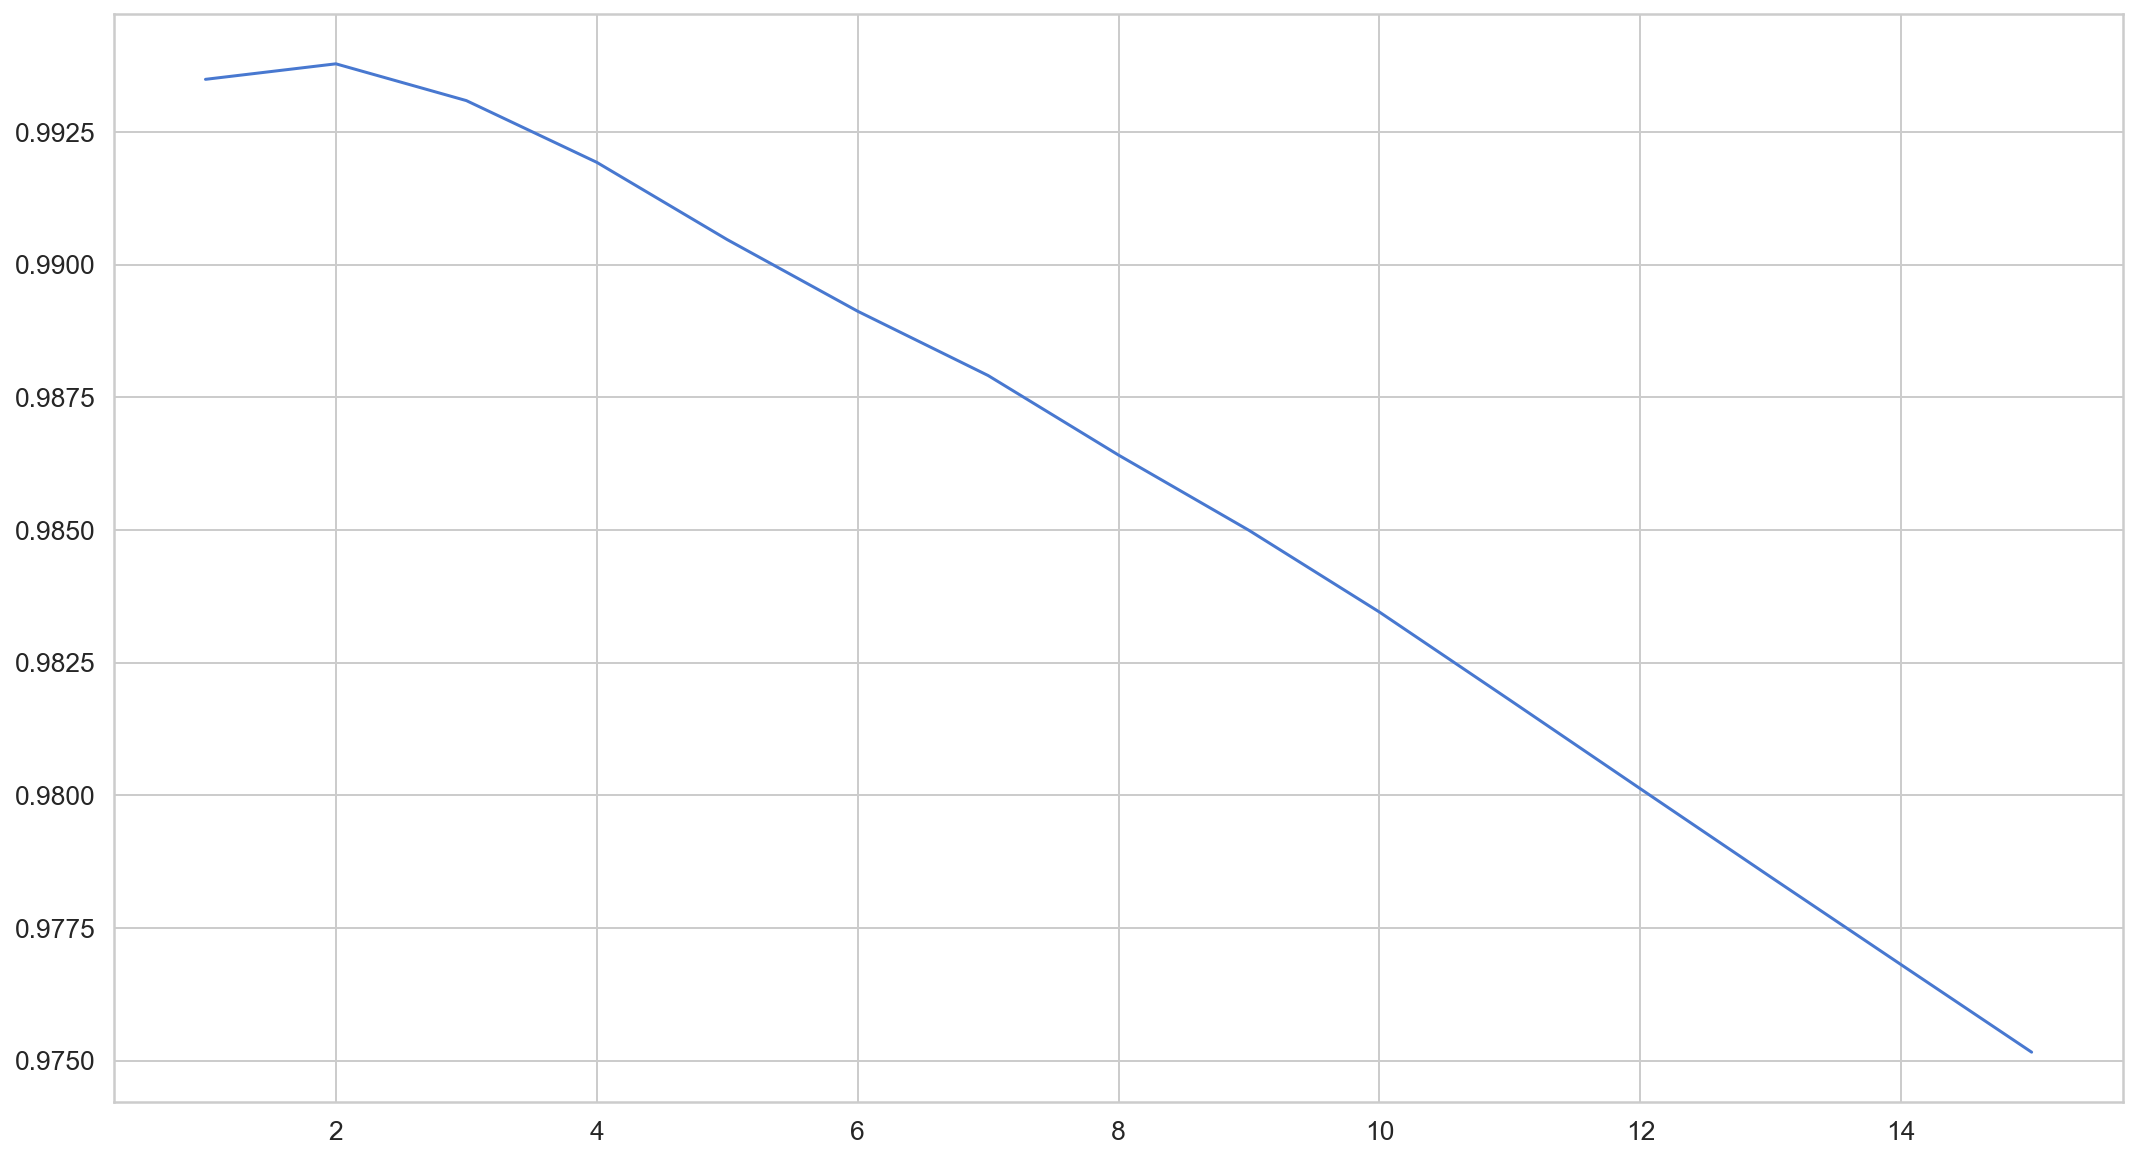

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,10))
plt.plot(range(1,16),scores)

In [43]:
model_knn = KNeighborsRegressor(n_neighbors=2)
model_knn.fit(x_train, y_train)

y_pred = model.predict(x_test)

mse_knn = mean_squared_error(y_test, y_pred)
r2_knn = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse_knn)
print("R-squared:", r2_knn)


Mean Squared Error: 8.709442550047818e-30
R-squared: 1.0


XG Boost

In [44]:
from xgboost import XGBRegressor
model = XGBRegressor()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

mse_xg = mean_squared_error(y_test, y_pred)
r2_xg = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse_xg)
print("R-squared:", r2_xg)

Mean Squared Error: 4.5457174953136995e-06
R-squared: 0.9999954317069623


Deep Neural Networks

Convolutional Neural Network

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
model = Sequential([
    Dense(64, activation='relu', input_shape=(45,)),
    Dense(64, activation='relu'),
    Dense(1)  # Assuming you have a regression task, change to Dense(num_classes, activation='softmax') for classification
])

# Compile the model
model.compile(optimizer='adam', loss='mse')  # Use 'categorical_crossentropy' for classification

# Train the model
model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
409/409 [==============================] - 1s 2ms/step - loss: 0.0993 - val_loss: 0.1016
Epoch 2/50
409/409 [==============================] - 1s 2ms/step - loss: 0.0629 - val_loss: 0.1481
Epoch 3/50
409/409 [==============================] - 1s 2ms/step - loss: 0.1062 - val_loss: 0.0476
Epoch 4/50
409/409 [==============================] - 1s 2ms/step - loss: 0.0311 - val_loss: 0.0306
Epoch 5/50
409/409 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0113
Epoch 6/50
409/409 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 7/50
409/409 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 8/50
409/409 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0045
Epoch 9/50
409/409 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0150
Epoch 10/50
409/409 [==============================] - 1s 2ms/step - loss: 0.0107 - val_loss: 0.0415

In [46]:
y_pred = model.predict(x_test)

mse_nn = mean_squared_error(y_test, y_pred)
r2_nn = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse_nn)
print("R-squared:", r2_nn)

Mean Squared Error: 0.00044420310934656094
R-squared: 0.9995535908305209


Long Short termed Memory

In [47]:
from tensorflow.keras.layers import LSTM, Dense

# Assuming x_train and x_test are pandas DataFrames
x_train = x_train.values.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1], 1))

# Create the LSTM model
model = Sequential([
    LSTM(64, input_shape=(x_train.shape[1], 1)),
    Dense(1)  # Assuming you have a regression task
])

# Compile the model
model.compile(optimizer='adam', loss='mse')  # Use 'categorical_crossentropy' for classification

# Train the model
model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
409/409 [==============================] - 12s 25ms/step - loss: 0.2458 - val_loss: 0.0265
Epoch 2/50
409/409 [==============================] - 9s 23ms/step - loss: 0.0143 - val_loss: 0.0096
Epoch 3/50
409/409 [==============================] - 10s 25ms/step - loss: 0.0069 - val_loss: 0.0038
Epoch 4/50
409/409 [==============================] - 14s 33ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 5/50
409/409 [==============================] - 25s 62ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 6/50
409/409 [==============================] - 13s 31ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 7/50
409/409 [==============================] - 11s 28ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 8/50
409/409 [==============================] - 11s 26ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 9/50
409/409 [==============================] - 12s 30ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 10/50
409/409 [==============================] - 13s 31ms/step - loss: 0.0020

In [48]:
# Make predictions
y_pred = model.predict(x_test)

mse_lstm = mean_squared_error(y_test, y_pred)
r2_lstm = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse_lstm)
print("R-squared:", r2_lstm)


Mean Squared Error: 0.0001110962071846674
R-squared: 0.9998883520521624


In [49]:
# R-squared values for each model
r2_values = {
    'Linear Regression': r2_lr,
    'KNN Regressor': r2_knn,
    'Decision Tree': r2_dt,
    'XGBoost': r2_xg,
    'Random Forest': r2_rf,
    'Neural Network': r2_nn,
    'LSTM': r2_lstm
}


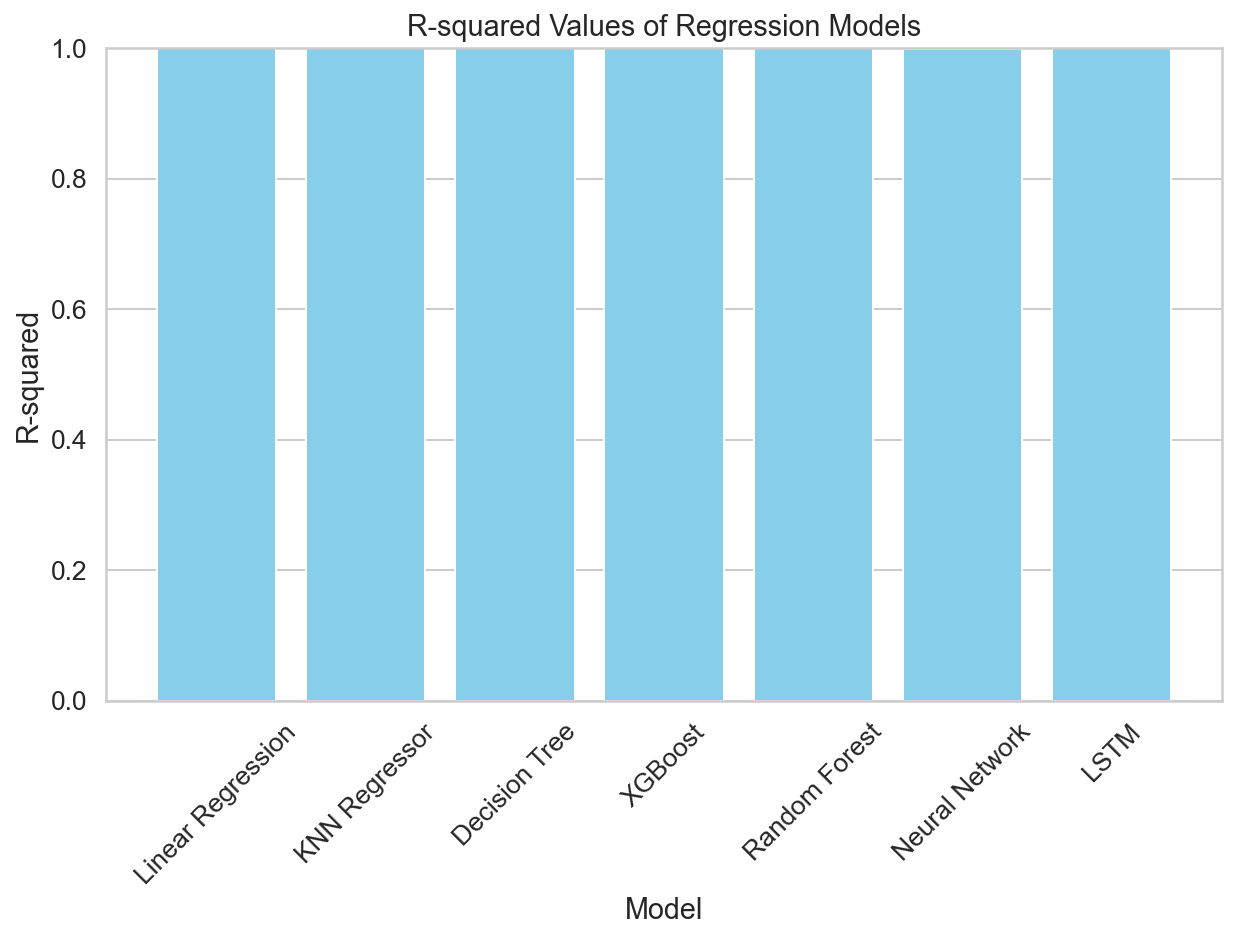

In [50]:
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(r2_values.keys(), r2_values.values(), color='skyblue')
plt.title('R-squared Values of Regression Models')
plt.xlabel('Model')
plt.ylabel('R-squared')
plt.ylim(0, 1)  # Set the y-axis limits to ensure visibility
plt.xticks(rotation=45)
plt.show()

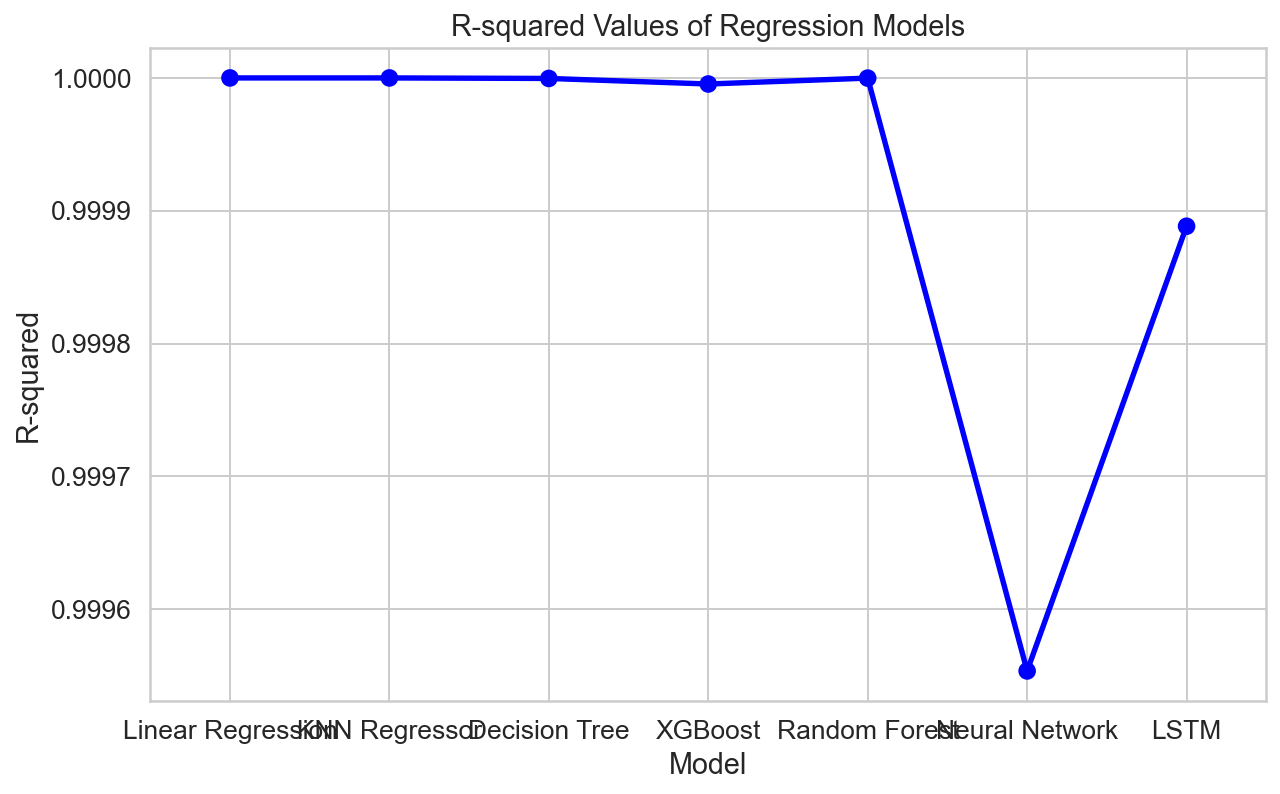

In [51]:
import seaborn as sns

r2_df = pd.DataFrame(r2_values.items(), columns=['Model', 'R-squared'])

# Create a point plot
plt.figure(figsize=(10, 6))
sns.pointplot(data=r2_df, x='Model', y='R-squared', color='blue')
plt.title('R-squared Values of Regression Models')
plt.xlabel('Model')
plt.ylabel('R-squared')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

CNN-LSTM

In [52]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten
x_train_array = x_train.to_numpy()
y_train_array = y_train.to_numpy()

# Reshape the input data for CNN (assuming the number of features is 1)
x_train_cnn = x_train_array.reshape((x_train_array.shape[0], x_train_array.shape[1], 1))


# Create the CNN-LSTM model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')  

# Fit the model
model.fit(x_train_cnn, y_train, epochs=50, batch_size=32, validation_split=0.2)

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [ ]:
# Make predictions
y_pred = model.predict(x_test)

mse_cnnlstm = mean_squared_error(y_test, y_pred)
r2_cnnlstm = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse_cnnlstm)
print("R-squared:", r2_cnnlstm)

273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean Squared Error: 0.0012905402379750407
R-squared: 0.9987030505106969
